In [1]:
from utils import SyntheticData, plot_decision_boundary, get_accuracy

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from pulp import *
import itertools
import copy
%matplotlib inline

class CompositeNetwork(nn.Module):
    def __init__(self, input_dimension, output_dimension, num_hidden_layers=10, neurons_per_layer=100):
        super(CompositeNetwork, self).__init__()
        
        def get_layer_with_elu(in_features, out_features, bias=True):
            return nn.Linear(in_features, out_features, bias=bias), nn.ELU()
        
        self.middle_dense = itertools.chain.from_iterable(get_layer_with_elu(in_features=neurons_per_layer, 
                                                                             out_features=neurons_per_layer) for i in range(num_hidden_layers-2))
    
        
        self.model = nn.Sequential(
            nn.Linear(in_features=input_dimension,
                      out_features=neurons_per_layer,
                      bias=True),
            nn.ELU(),
            *self.middle_dense, 
            )
        
        self.final = nn.Sequential(
            nn.Linear(in_features=neurons_per_layer,
                      out_features=output_dimension,
                      bias=True)
        )
        
    def forward(self, x):
        last_hidden = self.model(x)
        out = self.final(last_hidden)
        return out, last_hidden
    
    def predict(self, x):
        logits, _ = self.forward(x)
        return nn.Sigmoid()(logits) > 0.5
    
class SubNetwork(nn.Module):
    def __init__(self, composite_network, alpha):
        super(SubNetwork, self).__init__()
        self.comp_net = copy.deepcopy(composite_network)
        self.alpha = torch.from_numpy(alpha).reshape(-1, 1)
        
    def forward(self, x):
        _, last_hidden = self.comp_net(x)
        return last_hidden.mm(self.alpha), last_hidden
    
    def predict(self, x):
        sigmoid = nn.Sigmoid()
        logits, _ = self(x)
        return sigmoid(logits) > 0.5
        
def weight_initializer(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

L = 10
M = 100

net = CompositeNetwork(input_dimension=2, output_dimension=1, num_hidden_layers=L, neurons_per_layer=M)
net.apply(weight_initializer)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_data = SyntheticData(400, seed=1)
test_data = SyntheticData(10000, seed=10)

In [2]:
current_epoch = 0
while True:
    optimizer.zero_grad()
    outputs, _ = net(train_data.data)
    sigmoid = nn.Sigmoid()
    loss = criterion(sigmoid(outputs), train_data.target)
    loss.backward()
    optimizer.step()

    accuracy = get_accuracy(sigmoid(outputs), train_data.target)
    
    if current_epoch % 100 == 0:
        output_test, _ = net(test_data.data)
        accuracy_test = get_accuracy(output_test, test_data.target)
        print("Accuracy (train): %.3f. Accuracy (validation): %.3f. Loss: %.3f." % (accuracy, accuracy_test, loss.item()))
            
    current_epoch += 1
    #if accuracy == 1:
    #    print("Goal reached after %d epochs" % current_epoch)
    if current_epoch == 1000:
        break

Accuracy (train): 0.593. Accuracy (validation): 0.559. Loss: 0.912.
Accuracy (train): 0.875. Accuracy (validation): 0.860. Loss: 0.297.
Accuracy (train): 0.902. Accuracy (validation): 0.801. Loss: 0.232.
Accuracy (train): 0.943. Accuracy (validation): 0.785. Loss: 0.117.
Accuracy (train): 0.980. Accuracy (validation): 0.793. Loss: 0.053.
Accuracy (train): 1.000. Accuracy (validation): 0.796. Loss: 0.008.
Accuracy (train): 1.000. Accuracy (validation): 0.792. Loss: 0.003.
Accuracy (train): 1.000. Accuracy (validation): 0.790. Loss: 0.001.
Accuracy (train): 1.000. Accuracy (validation): 0.789. Loss: 0.001.
Accuracy (train): 1.000. Accuracy (validation): 0.789. Loss: 0.001.


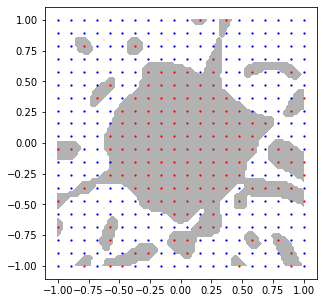

In [139]:
plot_decision_boundary(100, [net], train_data);

In [6]:
W_last = net.final[-1].weight.detach().numpy().ravel()
k = 8

model = pulp.LpProblem("Network Decomposition", pulp.LpMinimize)
alphas = pulp.LpVariable.dicts("alphas", (range(k), range(M)), None, None,  LpContinuous)

for i in range(M):
    model += lpSum([alphas[j][i] for j in range(k)]) == W_last[i] 
    
for i in range(k):
    for j in np.random.choice(M-1, size=int(M/2), replace=False):
        model += alphas[i][j] == 0
        
outputs, last_hidden = net(train_data.data)
last_hidden = last_hidden.detach().numpy()
y_out = outputs.detach().numpy().ravel()
y_hat = train_data.target.detach().numpy().ravel()
y_hat[y_hat == 0] = -1

for i in range(y_out.shape[0]):
    for j in range(k):
        model += lpSum([alphas[j][l] * last_hidden[i, l] for l in range(M)]) * y_hat[i] - 10e-6  >= 0

In [7]:
model.solve()

1

In [8]:
print("Status:", LpStatus[model.status])

Status: Optimal


In [9]:
varsdict = {}
for v in model.variables():
    varsdict[v.name] = v.varValue

a = np.empty(shape=(k, M), dtype=np.float32)

def result_to_matrix(model, k, M):
    a = np.empty(shape=(k, M), dtype=np.float32)
    for v in model.variables():
        name, i, j = v.name.split("_")
        if name == "alphas": 
            a[int(i), int(j)] = v.varValue
    return a
        
a = result_to_matrix(model, k, M)

In [10]:
from scipy.stats import logistic
import torch

def get_accuracy_numpy(probabilities, labels):
    predictions = (probabilities > 0.5)
    correct = (predictions  == labels.int().numpy()).sum()
    return float(correct)/len(labels)
    
for i in range(k):
    preds = logistic.cdf(last_hidden.dot(a[i,:]))
    train_data.target[train_data.target == -1] = 0
    print("Subnetwork %d accuracy: %.3f" % (i, get_accuracy_numpy(preds.reshape(400, 1), train_data.target)))

Subnetwork 0 accuracy: 1.000
Subnetwork 1 accuracy: 1.000
Subnetwork 2 accuracy: 1.000
Subnetwork 3 accuracy: 1.000
Subnetwork 4 accuracy: 1.000
Subnetwork 5 accuracy: 1.000
Subnetwork 6 accuracy: 1.000
Subnetwork 7 accuracy: 1.000


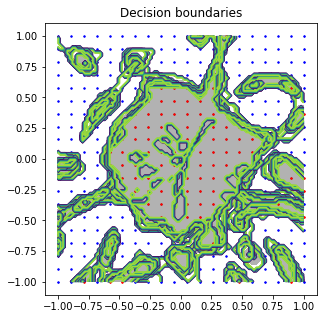

In [138]:
subnets = [SubNetwork(composite_network=net, alpha=a[i]) for i in range(k)]
ax = plot_decision_boundary(100, subnets, train_data, fill=False)
plot_decision_boundary(100, [net], train_data, fill=True, ax=ax);
ax.set_title("Decision boundaries");

In [108]:
def get_error_correlation(models, test_data):
    sigmoid = nn.Sigmoid()
    logits = [sigmoid(model(test_data.data)[0]) for model in models]
    losses = np.hstack([F.binary_cross_entropy(logit, test_data.target, reduction="none").detach().numpy() for logit in logits])
    return losses
    

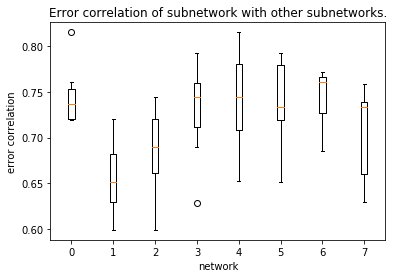

In [131]:
from matplotlib import pyplot as plt

errs = get_error_correlation(subnets, test_data)
fig, ax = plt.subplots(1)

corr_mat = np.abs(np.corrcoef(errs, rowvar=False))

for i in range(k):
    ax.boxplot(list(corr_mat[i, :i]) + list(corr_mat[i, i+1:]), positions=[i])
    
ax.set_title("Error correlation of subnetwork with other subnetworks.")
ax.set_xlabel("network")
ax.set_ylabel("error correlation");

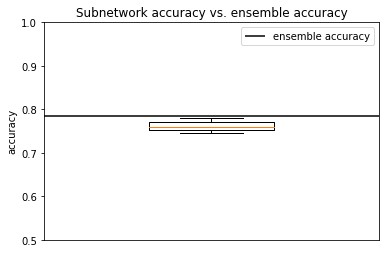

In [135]:
accs_subnets = [get_accuracy(subnet.predict(test_data.data), test_data.target) for subnet in subnets]
accs_ensemble = get_accuracy(net.predict(test_data.data), test_data.target)

fig, ax = plt.subplots(1)
ax.boxplot(accs_subnets, positions=[0.5])
ax.hlines([accs_ensemble], xmin=0.3, xmax=0.7, label="ensemble accuracy")
ax.set_ylim(0.5, 1)
ax.set_xlim(0.3, 0.7)
ax.set_xticks([])
ax.set_title("Subnetwork accuracy vs. ensemble accuracy")
ax.set_ylabel("accuracy")
ax.legend();